## Balancing Impact Notebook

---

### Objective:

- Given the chosen sampling rate, extraction interval and selected features, to assess the impact of different balancing strategies on the performance of the model.
- To determine the optimal balancing strategies for the model.

### Methodology:

- A model (RF, SVM, LR) is trained with selected features.
- The model is trained with 80% of the data and tested with the remaining 20%.

#### Findings:

Selected Features prior to the correlation analysis:

| Type                | N° Features |
| ------------------- | ---------- |
| MFCC                | 30         |
| CQT                 | 70         |
| Chroma              | 12         |
| RMS                 | 40         |
| Zero Crossing Rates | 40         |
| Spectral Centroid   | 40         |
| Spectral Bandwidth  | 60         |
| Spectral Rolloff    | 40         |


Selected Features after the correlation analysis:


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import tqdm.notebook as tqdm
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

In [3]:
# set the paths
BASE_DIR = "../../dataset/"
LABELS = BASE_DIR + "labels.csv"

# features
FEATURES_BASE = "../../features/"
FEATURES = FEATURES_BASE + "raw/"
#FEATURES = FEATURES_BASE + 'balanced/posteriori/'
#FEATURES = FEATURES_BASE + 'balanced/priori/'
#FEATURES = FEATURES_BASE + 'balanced/both/'

# Models
MODELS = "../../models/"
MODELS_RESULTS = MODELS + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

RESULT_NAME = "results_balancing_comparison_macrof1_train.csv"
BALANCING_TYPE = "none"
COMPLETE_DATA_PRIOR_CORR_NAME = f'full_data_{BALANCING_TYPE}_bal_{INTERVAL}s_4000hz_30mfcc_12chroma_70cqt_41rms_41zcr_41sc_61sb_41sr_FILENAME.npy'

In [4]:
# -----------------------------------------Constants-----------------------------------------
SEED = 42
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
#full_data_dict_keys = ["extrahls", "extrastoles"] #PRIORI BALANCED CLASSES

interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = ["mix", 4000]
num_feats = {
    "30 MFCC": "30mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "70cqt",
    "40 RMS": "41rms",
    "40 Zero Crossing Rates": "41zcr",
    "40 Spectral Centroid": "41sc",
    "60 Spectral Bandwidth": "61sb",
    "40 Spectral Rolloff": "41sr",
}

### FEATURES EXTRACTION - CHOSE THE CORRECT ONE

In [6]:
# -------------------------- PRIORI BALANCED AND NONE VERSION -----------------------------------------

# create a unique dataset
full_X = []
full_y = []
full_filename = []
for name,num_feat in num_feats.items():
     print(f"Processing 4000hz_{num_feat}")

     # Load the data
     FEATURES_NAME = f"full_data_{interval}s_4000hz_{num_feat}.npy"
     full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()

     # Extract data from the dictionary
     data_list = []
     X_list = []
     y_list = []
     filename_list = []
     for key in full_data_dict_keys:
          X = full_data[key]["X"] # (n_samples_class_key, num_feat)
          y = full_data[key]["y"] # (n_samples_class_key,)
          filename = full_data[key]['filename']
          X_list.append(X) 
          y_list.append(y)
          filename_list.append(filename)
     full_X.append(np.concatenate(X_list, axis=0)) # (n_samples, num_feat)
     full_y = np.concatenate(y_list, axis=0) # (n_samples,)
     full_filename = np.concatenate(filename_list, axis = 0)
     print(f"Shape of X: {full_X[-1].shape}\n")
features = np.hstack(full_X) # (n_samples, num_feats_total)

# Concatenate all the features
full_data_array = np.hstack((features, full_y.reshape(-1, 1), full_filename.reshape(-1, 1)))
print(f"Shape of full_data_array: {full_data_array.shape}")

# split the data
X = full_data_array[:, :-2]
y = full_data_array[:, -2]
filename = full_data_array[:, -1]
X_train, X_test, y_train, y_test, filename_train, filename_test = train_test_split(X, y, filename, test_size=0.01, random_state=SEED)

# create the full dict
full_dict = {
     'train' : {
     'X' : X_train,
     'y' : y_train,
     'filename' : filename_train
},
     'test' : {
     'X' : X_test,
     'y' : y_test,
     'filename' : filename_test
}
}

# save the data
np.save(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, full_dict)

Processing 4000hz_30mfcc
Shape of X: (4880, 30)

Processing 4000hz_12chroma
Shape of X: (4880, 12)

Processing 4000hz_70cqt
Shape of X: (4880, 70)

Processing 4000hz_41rms
Shape of X: (4880, 41)

Processing 4000hz_41zcr
Shape of X: (4880, 41)

Processing 4000hz_41sc
Shape of X: (4880, 41)

Processing 4000hz_61sb
Shape of X: (4880, 61)

Processing 4000hz_41sr
Shape of X: (4880, 41)

Shape of full_data_array: (4880, 339)


In [5]:
# -------------------------- POSTERIORI BALANCED AND BOTH VERSION -----------------------------------------

# create a unique dataset - for posteriori balancing since this latter has a different structure of the data dictionary with all classes already splitted in train and test
full_data_dict_keys = ['train_bal', 'test']

X_list_test = []
y_list_test = []
X_list_train = []
y_list_train = []

for name,num_feat in num_feats.items():
     print(f"Processing 4000hz_{num_feat}")

     # Load the data
     FEATURES_NAME = f"full_data_{interval}s_4000hz_{num_feat}.npy"
     full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()

     # Extract data from the dictionary

     
     
     X_train = full_data['train_unb']["X"] # (n_samples, num_feat)
     y_train = full_data['train_unb']["y"] # (n_samples,)
     X_list_train.append(X_train)
     
     X_test = full_data['test']["X"] # (n_samples, num_feat)
     y_test = full_data['test']["y"] # (n_samples,)
     X_list_test.append(X_test)
     
X_train = np.hstack(X_list_train) # (n_samples, num_feats_total)
X_test = np.hstack(X_list_test) # (n_samples, num_feats_total)

# create the full dict
full_dict = {
     'train' : {
     'X' : X_train,
     'y' : y_train
},
     'test' : {
     'X' : X_test,
     'y' : y_test
}
}

# save the data
np.save(FEATURES + COMPLETE_DATA_PRIOR_CORR_NAME, full_dict)

Processing 4000hz_30mfcc


KeyError: 'train_unb'

### MODEL TRAINING

Training Random Forest

Training SVM

Training Logistic Regression



/home/ligari/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Random Forest

Training SVM

Training Logistic Regression



/home/ligari/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,none,posteriori
Random Forest,0.60877,0.669616
SVM,0.384995,0.454817
Logistic Regression,0.515177,0.473209


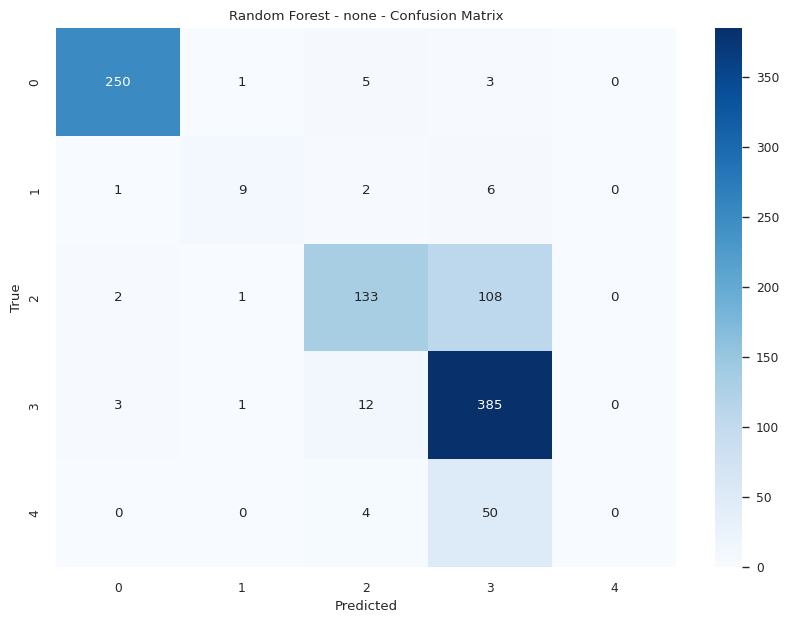

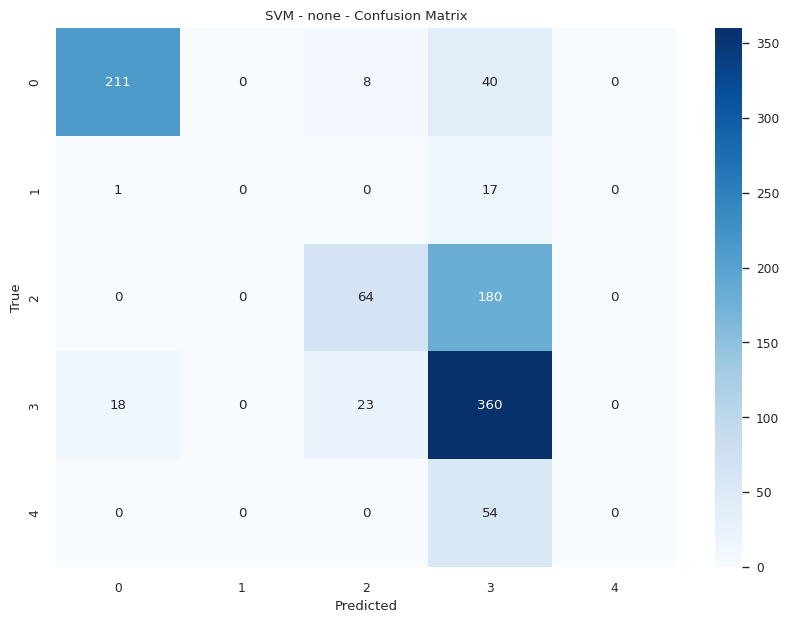

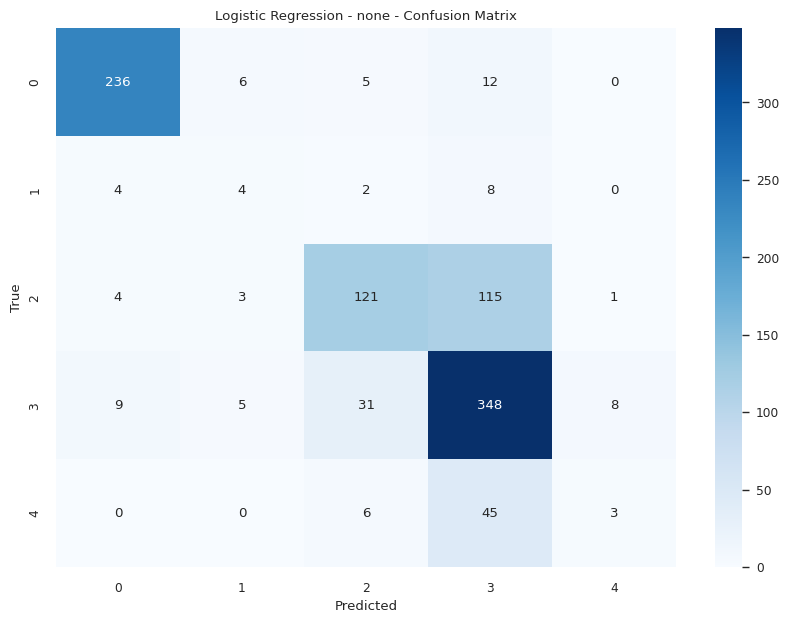

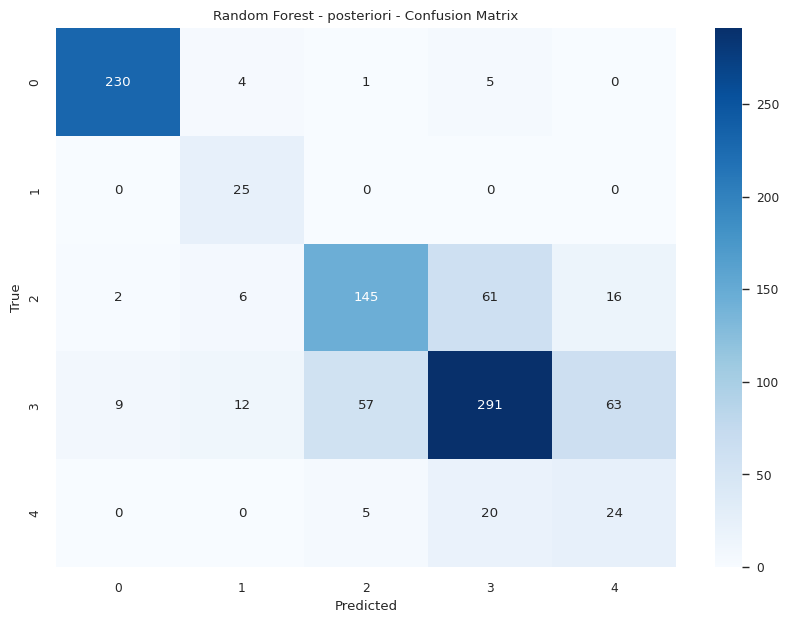

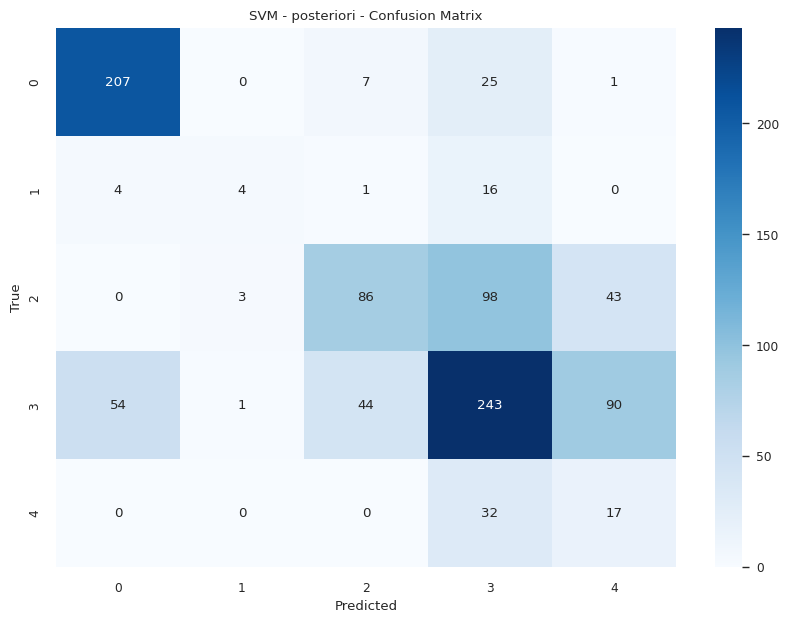

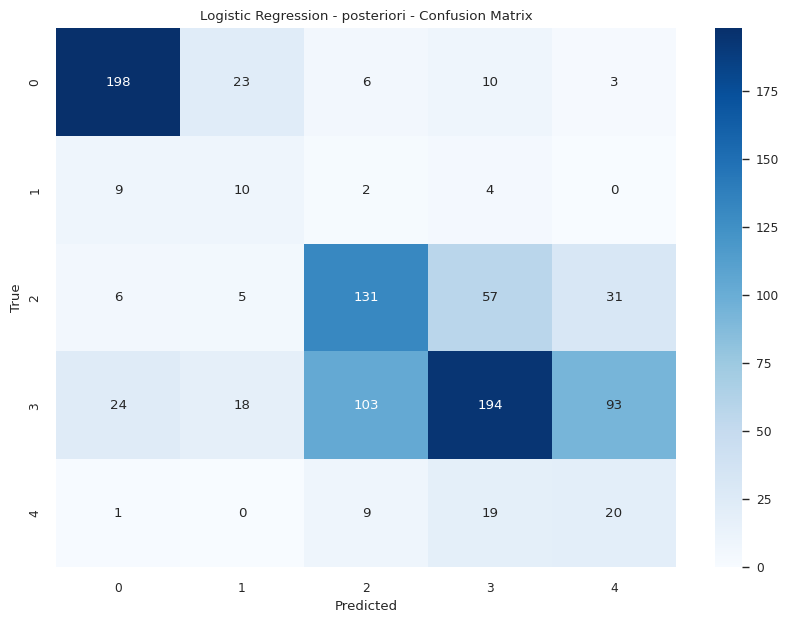

In [6]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------
balancing_types = ["none", "posteriori"]
result_df = pd.DataFrame(
    columns=balancing_types,
    index=["Random Forest", "SVM", "Logistic Regression"],
)

# ----------------------------------------- Loop over each feature-----------------------------------------
for type_ in balancing_types:

    # take the correct path
    if type_ == 'none':
        FEATURES = FEATURES_BASE + 'raw/'
    else:
        FEATURES = FEATURES_BASE + f'balanced/{type_}/'

    # Load the data
    FEATURES_NAME = f'full_data_{type_}_bal_{INTERVAL}s_4000hz_30mfcc_12chroma_70cqt_41rms_41zcr_41sc_61sb_41sr.npy'
    full_data = np.load(FEATURES + FEATURES_NAME, allow_pickle=True).item()

    # Extract data from the dictionary
    X_train = full_data["train"]["X"]
    y_train = full_data["train"]["y"]
    X_test = full_data["test"]["X"]
    y_test = full_data["test"]["y"]

    # Train and evaluate models: Random Forest, SVM, Logistic Regression
    for model_name, clf in {
        "Random Forest": RandomForestClassifier(random_state=SEED),
        "SVM": SVC(random_state=SEED),
        "Logistic Regression": LogisticRegression(random_state=SEED, max_iter=1000),
    }.items():
        print(f"Training {model_name}\n")
        clf.fit(X_train, y_train)
        #score = clf.score(X_test, y_test)
        #score = clf.score(X_train, y_train)
        
        # macrof1
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred, average='macro')
        
        # cf
        y_pred = clf.predict(X_test)
        cf = confusion_matrix(y_test, y_pred)
         
        # plot cf
        plt.figure(figsize=(10, 7))
        sns.heatmap(cf, annot=True, cmap="Blues", fmt="d")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"{model_name} - {type_} - Confusion Matrix")
        
        # save the plot
        plt.savefig(IMAGES_PATH + f'{model_name}_{type_}_confusion_matrix.png')
        
        
        result_df.loc[model_name, type_] = score

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
result_df

(array([0.5, 1.5]), [Text(0, 0.5, 'none'), Text(0, 1.5, 'posteriori')])

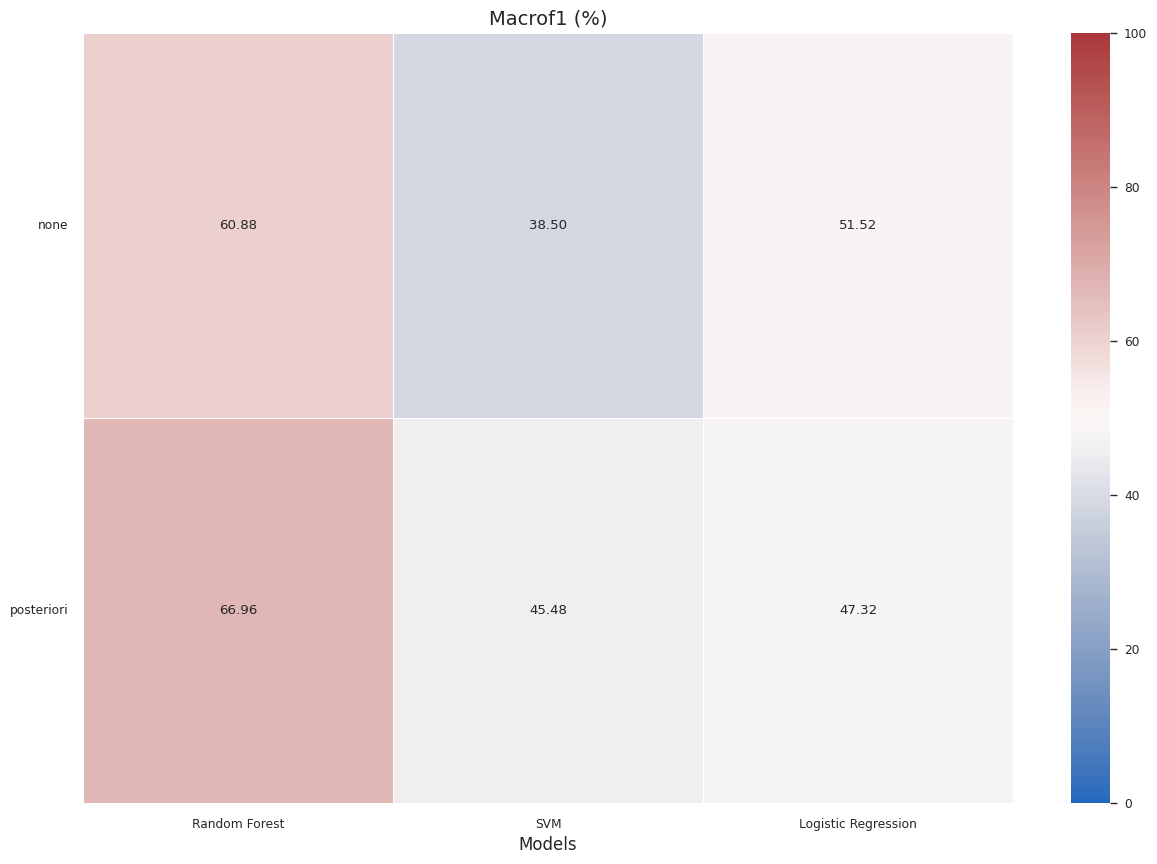

In [7]:
result_df = pd.read_csv(MODELS_RESULTS + RESULT_NAME, index_col=0).transpose()

plt.figure(figsize=(15, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(result_df.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f",vmax=100,vmin=0,linewidths=0.5)
#plt.title("Accuracy (%)", fontsize=14)
plt.title("Macrof1 (%)", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.yticks(rotation=0)

/home/ligari/.local/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/ligari/.local/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, 'Macro F1'),
  Text(0, 1.5, 'Macro Precision'),
  Text(0, 2.5, 'Macro Recall'),
  Text(0, 3.5, 'Test Acc'),
  Text(0, 4.5, 'both'),
  Text(0, 5.5, 'none'),
  Text(0, 6.5, 'posteriori'),
  Text(0, 7.5, 'priori')])

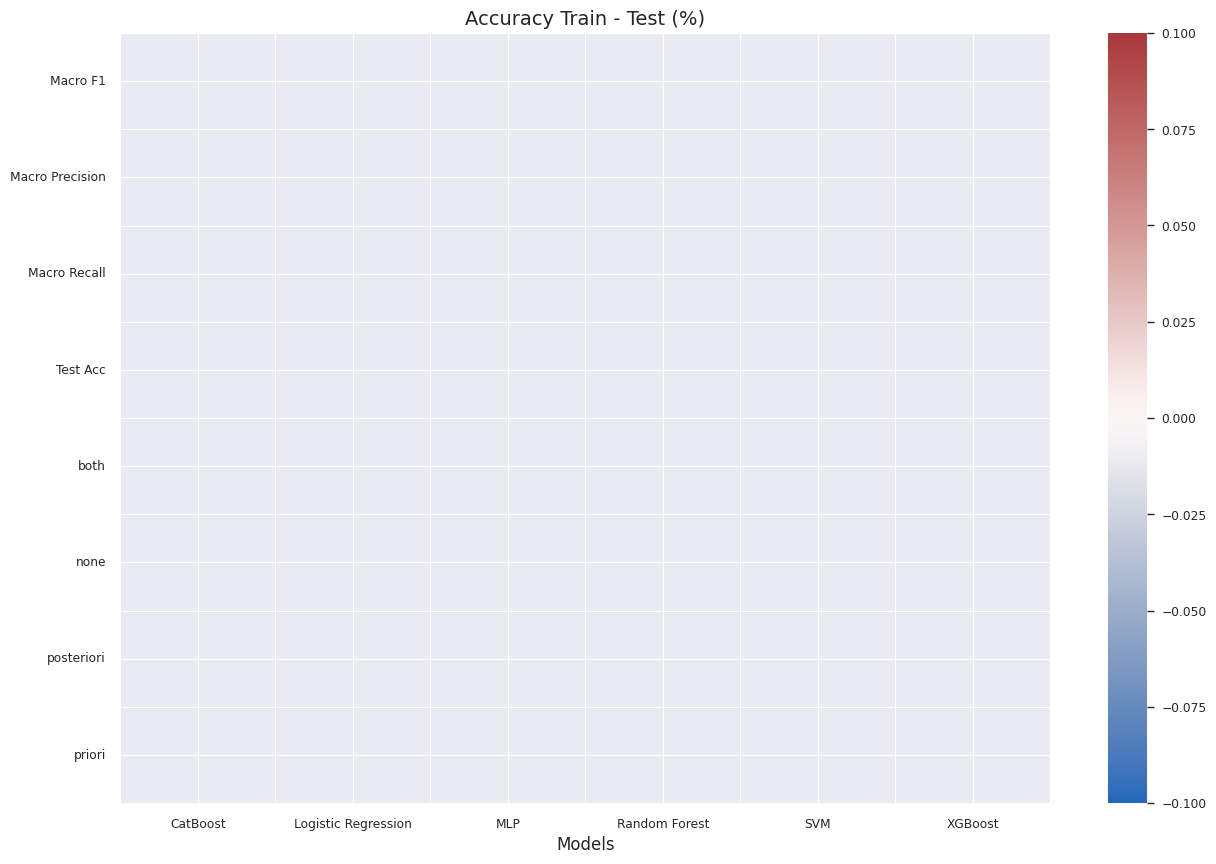

In [8]:
RESULT_NAME = "results_balancing_comparison_train.csv"
result_df_train = pd.read_csv(MODELS_RESULTS + RESULT_NAME, index_col=0).transpose()

RESULT_NAME = "results_balancing_comparison_test.csv"
result_df_test = pd.read_csv(MODELS_RESULTS + RESULT_NAME, index_col=0).transpose()

# difference
result_df = result_df_train - result_df_test

plt.figure(figsize=(15, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(result_df.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f",linewidths=0.5)
plt.title("Accuracy Train - Test (%)", fontsize=14)
plt.xlabel("Models", fontsize=12)
plt.yticks(rotation=0)

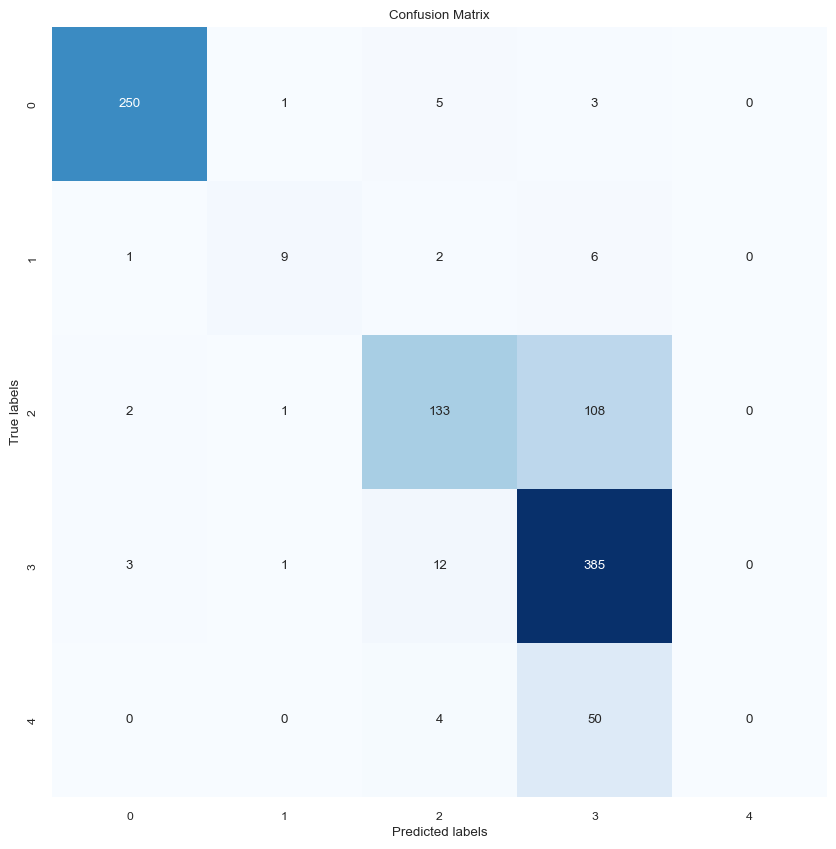

F1 score: 0.6087697205554254


KeyError: 'filename'

In [9]:
import os
def get_wrong_pred_filename(data_full_path, y_pred):
	# load the data
	full_data = np.load(data_full_path, allow_pickle=True).item()
	X_train, y_train, filename_train = full_data['train']['X'], full_data['train']['y'], full_data['train']['filename']
	X_test, y_test, filename_test = full_data['test']['X'], full_data['test']['y'], full_data['test']['filename']

	label_to_dir_dict = {
	0: f'{BASE_DIR}artifacts_4000/',
	1: f'{BASE_DIR}extrahls_4000/',
	2: f'{BASE_DIR}murmurs_4000/',
	3: f'{BASE_DIR}normals_4000/',
	4: f'{BASE_DIR}extrastoles_4000/',
	}
     
	# find wrong predictions
	wrong_pred = np.where(y_pred != y_test)[0]
	correct_pred = np.where(y_pred == y_test)[0]

	# keep wrong pred only if the actual class was 2 or 4
	wrong_pred = [i for i in wrong_pred if y_test[i] in [1,4]]
	correct_pred = [i for i in correct_pred if y_test[i] in [1,4]]
	
	# recover the filename from the train set labels
	filenames = []
	for i in wrong_pred:
		filenames.append(os.listdir(label_to_dir_dict[int(y_test[i])])[int(filename_test[i])])

	count = 0
	for name in filenames:
		if 'USERAUGMENTED' in name:
			count += 1

	print(f"Number of wrong predictions: {len(wrong_pred)}")
	print(f"Number of wrong predictions with USERAUGMENTED: {count}")

	filenames = []
	for i in correct_pred:
		filenames.append(os.listdir(label_to_dir_dict[int(y_test[i])])[int(filename_test[i])])

	count = 0
	for name in filenames:
		if 'USERAUGMENTED' in name:
			count += 1

	print(f"Number of correct predictions: {len(correct_pred)}")
	print(f"Number of correct predictions with USERAUGMENTED: {count}")
 

# test the function
#full_data = np.load('../../features/balanced/posteriori/' + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()
full_data = np.load('../../features/raw/' + COMPLETE_DATA_PRIOR_CORR_NAME, allow_pickle=True).item()

# train a model
X_train = full_data['train']['X']
y_train = full_data['train']['y']
X_test = full_data['test']['X']
y_test = full_data['test']['y']

clf = RandomForestClassifier(random_state=SEED)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# PRITN THE CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute the F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 score: {f1}")

# get the wrong predictions
#get_wrong_pred_filename('../../features/balanced/posteriori/' + COMPLETE_DATA_PRIOR_CORR_NAME, y_pred)
get_wrong_pred_filename('../../features/raw/' + COMPLETE_DATA_PRIOR_CORR_NAME, y_pred)

